In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./data/Motor vehicle insurance data.csv", sep=';')

In [3]:
df.columns

Index(['ID', 'Date_start_contract', 'Date_last_renewal', 'Date_next_renewal',
       'Date_birth', 'Date_driving_licence', 'Distribution_channel',
       'Seniority', 'Policies_in_force', 'Max_policies', 'Max_products',
       'Lapse', 'Date_lapse', 'Payment', 'Premium', 'Cost_claims_year',
       'N_claims_year', 'N_claims_history', 'R_Claims_history', 'Type_risk',
       'Area', 'Second_driver', 'Year_matriculation', 'Power',
       'Cylinder_capacity', 'Value_vehicle', 'N_doors', 'Type_fuel', 'Length',
       'Weight'],
      dtype='object')

In [4]:
df.isnull().sum()

ID                          0
Date_start_contract         0
Date_last_renewal           0
Date_next_renewal           0
Date_birth                  0
Date_driving_licence        0
Distribution_channel        0
Seniority                   0
Policies_in_force           0
Max_policies                0
Max_products                0
Lapse                       0
Date_lapse              70408
Payment                     0
Premium                     0
Cost_claims_year            0
N_claims_year               0
N_claims_history            0
R_Claims_history            0
Type_risk                   0
Area                        0
Second_driver               0
Year_matriculation          0
Power                       0
Cylinder_capacity           0
Value_vehicle               0
N_doors                     0
Type_fuel                1764
Length                  10329
Weight                      0
dtype: int64

In [5]:
# Convert date columns to datetime format
date_columns = ['Date_lapse', 'Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 'Date_birth', 'Date_driving_licence']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [6]:
# Generate
df['Age'] = (df['Date_last_renewal'] - df['Date_birth']) // pd.Timedelta('365 days')
df['yoe'] = (df['Date_last_renewal'] - df['Date_driving_licence']) // pd.Timedelta('365 days')
df['contract_duration'] = (df['Date_last_renewal'] - df['Date_start_contract']) // pd.Timedelta('365 days')
df['Claim_frequency'] = df['N_claims_history'] / df['Seniority']

In [7]:
# Ensure numeric columns are properly formatted
numeric_columns = ['Seniority',
                    'Policies_in_force',
                    'Max_policies',
                    'Max_products',
                    'Lapse',
                    'Premium',
                    'Cost_claims_year',
                    'N_claims_year',
                    'N_claims_history',
                    'R_Claims_history',
                    'Year_matriculation',
                    'Power',
                    'Cylinder_capacity',
                    'Value_vehicle',
                    'N_doors',
                    'Length',
                    'Weight',
                    'Age',
                    'yoe',
                    'contract_duration',
                    'Claim_frequency']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

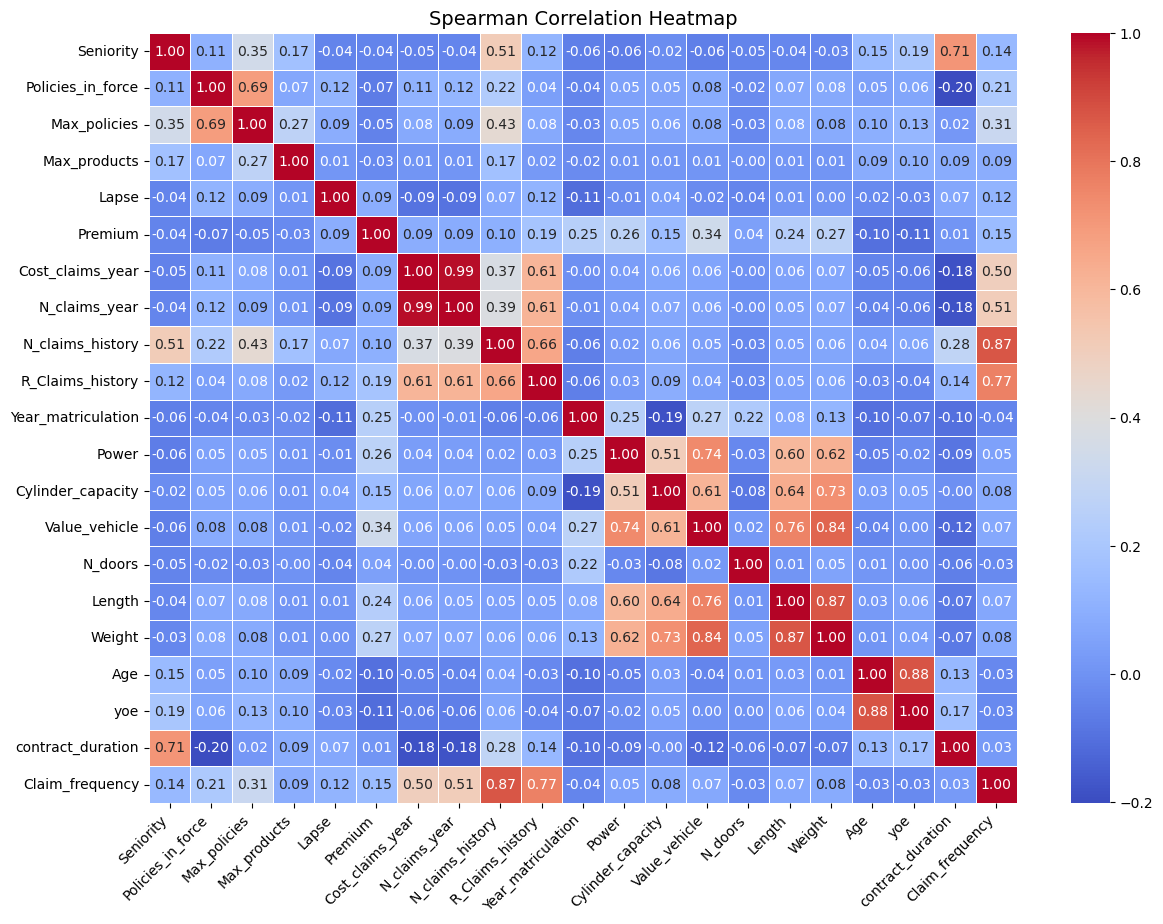

In [8]:
# Correlation Heatmap for All Columns
# Drop NaN values for correlation computation
df_filtered = df[numeric_columns].dropna()

# Compute Spearman correlation (handles non-linear relationships)
corr_matrix = df_filtered.corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(14, 10))  # Bigger size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
            annot_kws={"size": 10})  # Adjust font size
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.title('Spearman Correlation Heatmap', fontsize=14)
plt.show()


In [9]:
## Policy and Customer Characteristics
policy_customer_features = [
    'Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 
    'Distribution_channel',
    'Seniority', 'Policies_in_force', 'Max_policies', 'Max_products', 
    'Lapse', 'Payment', 'Age', 'yoe', 'contract_duration'
]

df[policy_customer_features]

,Date_start_contract,Date_last_renewal,Date_next_renewal,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,Age,yoe,contract_duration
0,2015-05-11,2015-05-11,2016-05-11,0,4,1,2,1,0,0,59.0,39.0,0.0
1,2015-05-11,2016-05-11,2017-05-11,0,4,1,2,1,0,0,60.0,40.0,1.0
2,2015-05-11,2017-05-11,2018-05-11,0,4,2,2,1,0,0,61.0,41.0,2.0
3,2015-05-11,2018-05-11,2019-05-11,0,4,2,2,1,0,0,62.0,42.0,3.0
4,NaT,NaT,NaT,0,4,2,2,1,0,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105550,NaT,NaT,NaT,0,1,1,1,1,0,0,NaN,NaN,NaN
105551,NaT,NaT,NaT,0,1,1,1,1,0,0,NaN,NaN,NaN
105552,NaT,NaT,NaT,0,1,1,1,1,0,1,NaN,NaN,NaN
105553,NaT,NaT,NaT,0,1,1,1,1,0,0,NaN,NaN,NaN


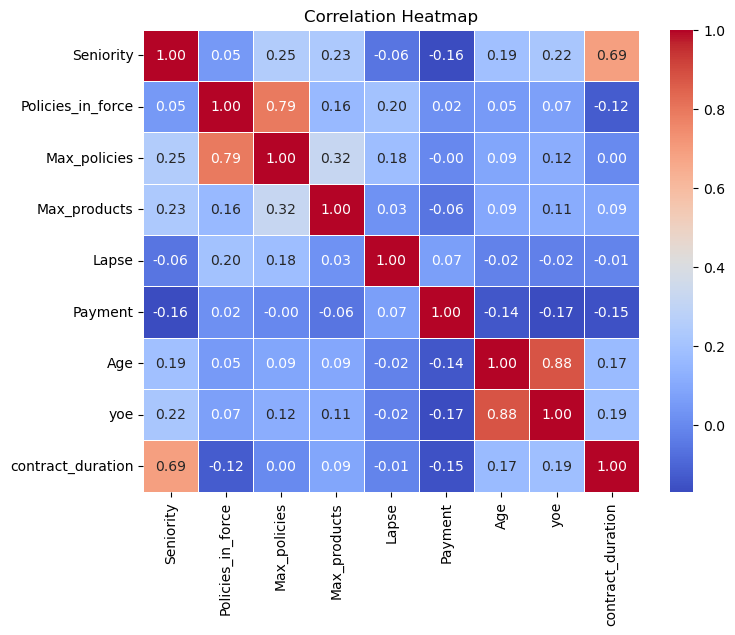

In [10]:
# Correlation Heatmap for Customer
plt.figure(figsize=(8, 6))
corr_matrix = df[policy_customer_features].select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [11]:
## Vehicle Characteristics
vehicle_features = [
    'Type_risk', 'Area', 'Second_driver', 'Year_matriculation', 'Power',
    'Cylinder_capacity', 'Value_vehicle', 'N_doors', 'Type_fuel', 'Length', 'Weight'
]

df[vehicle_features]

,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight
0,1,0,0,2004,80,599,7068.00,0,P,NaN,190
1,1,0,0,2004,80,599,7068.00,0,P,NaN,190
2,1,0,0,2004,80,599,7068.00,0,P,NaN,190
3,1,0,0,2004,80,599,7068.00,0,P,NaN,190
4,1,0,0,2004,80,599,7068.00,0,P,NaN,190
...,...,...,...,...,...,...,...,...,...,...,...
105550,3,0,0,2000,110,1997,24320.00,5,D,4.740,1480
105551,3,0,0,2013,129,1998,30861.97,5,P,4.650,1440
105552,3,0,0,1999,55,999,7800.00,5,P,3.495,830
105553,2,0,0,2004,90,1753,16610.00,5,D,4.555,1399


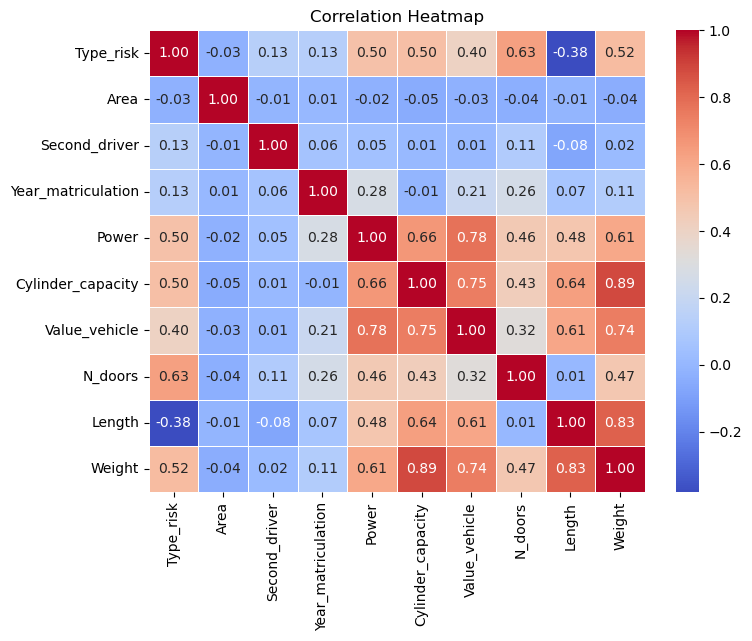

In [12]:
# Correlation Heatmap for Vehicles
plt.figure(figsize=(8, 6))
corr_matrix = df[vehicle_features].select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


## Claim History

In [13]:
## Claim History
claim_history_features = ['Cost_claims_year', 'N_claims_year', 
                          'N_claims_history', 'R_Claims_history', 
                          'Claim_frequency']

df[claim_history_features]

,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Claim_frequency
0,0.0,0,0,0.0,0.0
1,0.0,0,0,0.0,0.0
2,0.0,0,0,0.0,0.0
3,0.0,0,0,0.0,0.0
4,0.0,0,0,0.0,0.0
...,...,...,...,...,...
105550,0.0,0,0,0.0,0.0
105551,0.0,0,0,0.0,0.0
105552,0.0,0,0,0.0,0.0
105553,0.0,0,0,0.0,0.0


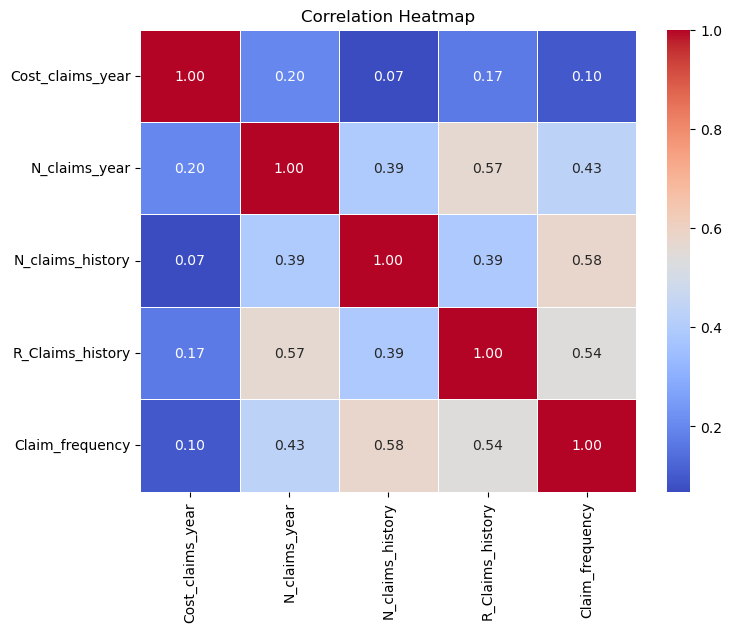

In [14]:
# Correlation Heatmap for Claims
plt.figure(figsize=(8, 6))
corr_matrix = df[claim_history_features].select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [16]:
# Define the target variable
label = "Cost_claims_year"

# Select only numerical features and drop the target variable
X = df[claim_history_features]

# Fill NaNs (if any) with median to avoid issues
X = X.fillna(X.median())
y = df[label].fillna(df[label].median())  # Fill NaNs in target variable

# Fit Linear Regression Model
lr = LinearRegression()
lr.fit(X, y)

# Compute R-squared
r2 = r2_score(y, lr.predict(X))
print("R2 Score:", r2)

# Compute Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)


R2 Score: 1.0
Variance Inflation Factor (VIF):
            Feature       VIF
0  Cost_claims_year  1.058369
1     N_claims_year  1.779796
2  N_claims_history  2.089290
3  R_Claims_history  2.260656
4   Claim_frequency  2.476115


### Histogram for Distribution

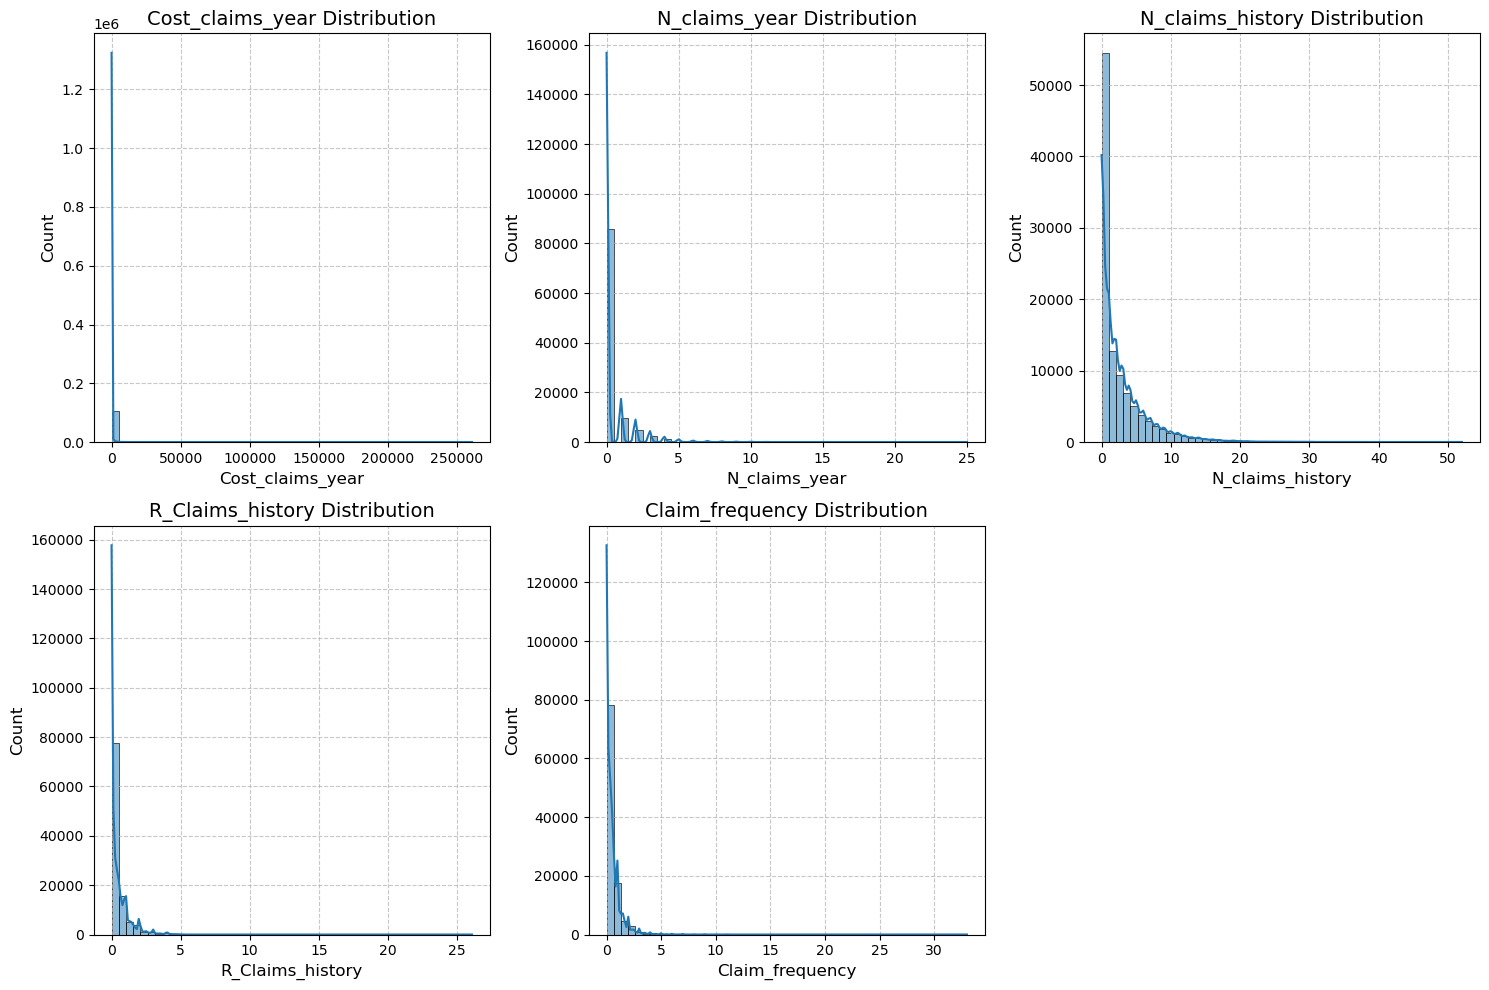

In [17]:
num_rows = 2  
num_cols = 3  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

# Generate plots
for i, col in enumerate(claim_history_features):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} Distribution', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.7)  # Add grid with dashed lines

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Pairplot

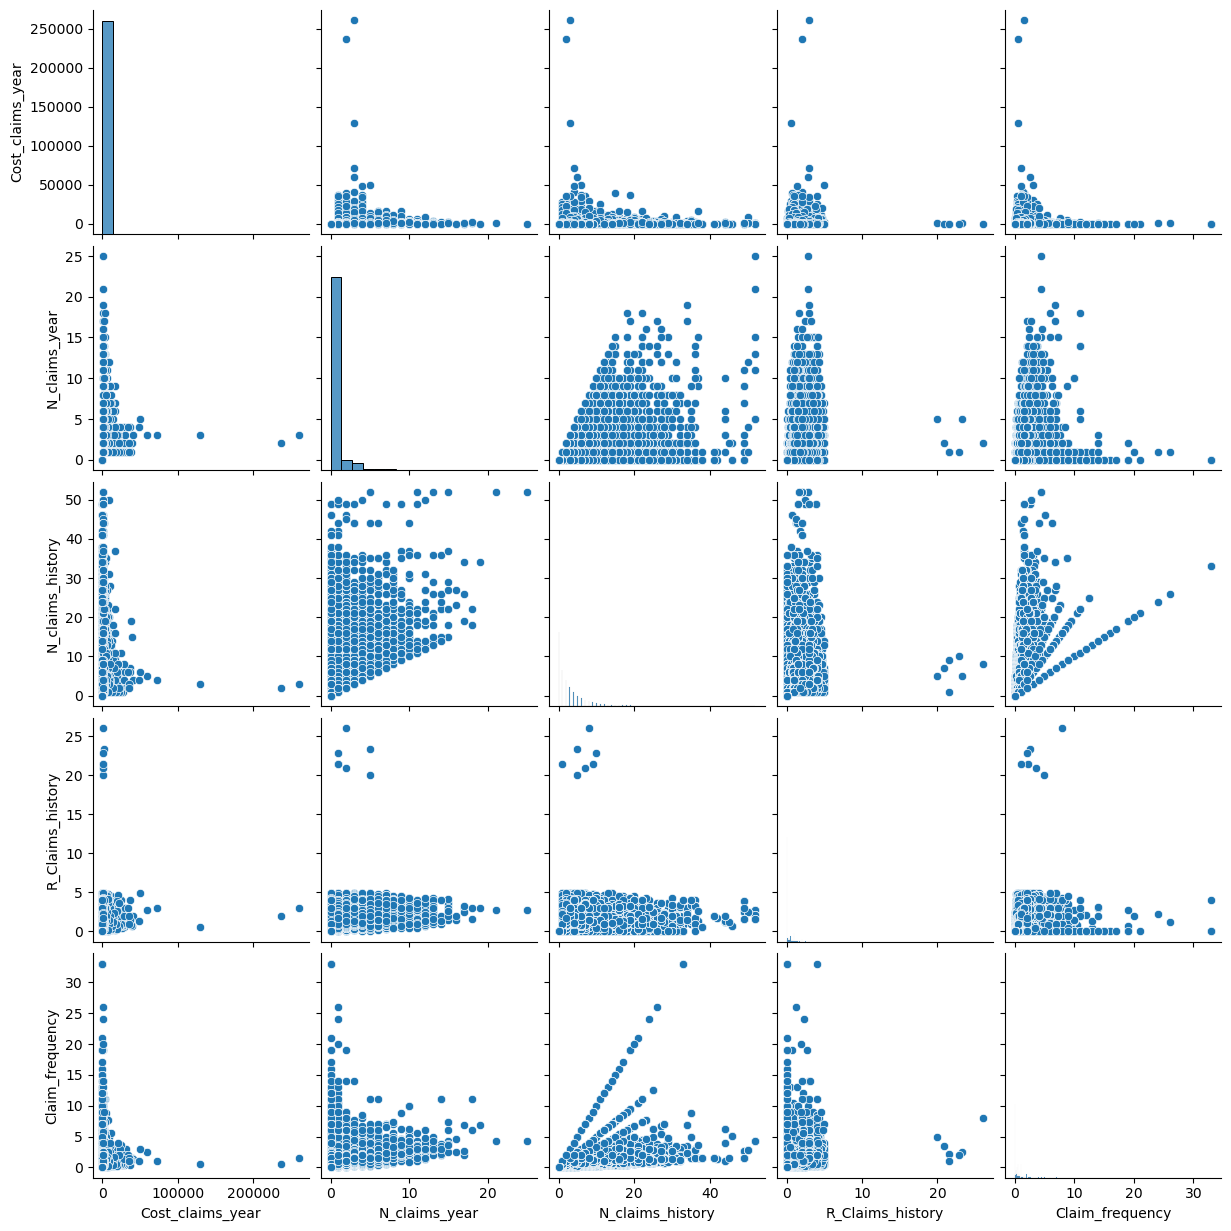

In [18]:
# Pairplot for deeper insights
sns.pairplot(df[claim_history_features])
plt.show()

## Cost clains year

In [19]:
independent_features = ['contract_duration', 'Distribution_channel', 'yoe', 
                        'Seniority', 'Policies_in_force', 'Max_products', 'Payment', 
                        'Premium', 'N_claims_year', 'N_claims_history', 'R_Claims_history', 
                        'Value_vehicle', 'N_doors']
dependent_feature = 'Cost_claims_year'


In [20]:
df[independent_features] = df[independent_features].apply(pd.to_numeric, errors='coerce')
df[dependent_feature] = pd.to_numeric(df[dependent_feature], errors='coerce')

# Fill missing values with median
df[independent_features] = df[independent_features].fillna(df[independent_features].median())
df[dependent_feature] = df[dependent_feature].fillna(df[dependent_feature].median())


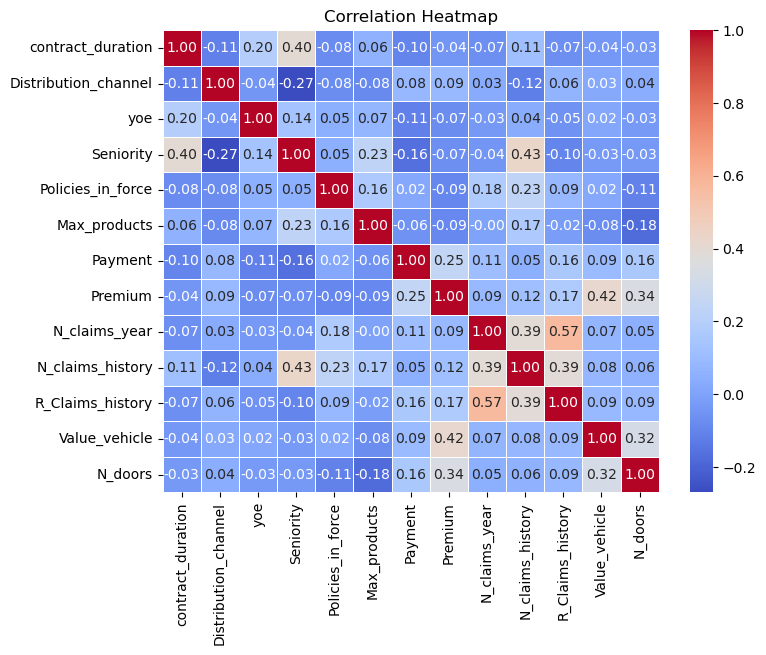

In [21]:
# Correlation Heatmap for independent_features
plt.figure(figsize=(8, 6))
corr_matrix = df[independent_features].select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [22]:
# Define X and y
X = df[independent_features]
y = df[dependent_feature]

# Fit Linear Regression Model
lr = LinearRegression()
lr.fit(X, y)

# Compute R-squared
r2 = r2_score(y, lr.predict(X))
print(f"R2 Score: {r2}")

# Compute Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
print("Variance Inflation Factor (VIF):")
print(vif_data)


R2 Score: 0.04616062453621228
Variance Inflation Factor (VIF):
                 Feature        VIF
0      contract_duration   1.791877
1   Distribution_channel   1.924148
2                    yoe   8.186546
3              Seniority   3.712119
4      Policies_in_force   3.762755
5           Max_products  11.250027
6                Payment   1.648759
7                Premium   8.020617
8          N_claims_year   1.799416
9       N_claims_history   2.653921
10      R_Claims_history   2.238399
11         Value_vehicle   6.420537
12               N_doors   8.544454


In [23]:
independent_features_new = ['contract_duration', 'Distribution_channel',  
                        'Seniority', 'Policies_in_force', 'Payment', 
                        'N_claims_year', 'N_claims_history', 'R_Claims_history', 'Premium',
                        'Value_vehicle']
dependent_feature = 'Cost_claims_year'

df[independent_features_new] = df[independent_features_new].apply(pd.to_numeric, errors='coerce')
df[dependent_feature] = pd.to_numeric(df[dependent_feature], errors='coerce')

# Fill missing values with median
df[independent_features_new] = df[independent_features_new].fillna(df[independent_features_new].median())
df[dependent_feature] = df[dependent_feature].fillna(df[dependent_feature].median())


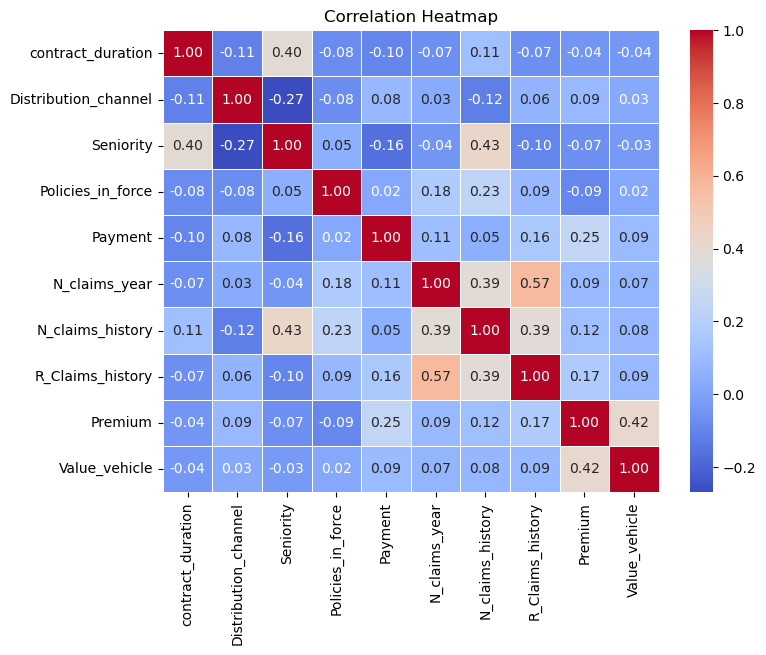

In [24]:
# Correlation Heatmap for independent_features
plt.figure(figsize=(8, 6))
corr_matrix = df[independent_features_new].select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [25]:
# Define X and y
X = df[independent_features_new]
y = df[dependent_feature]

# Fit Linear Regression Model
lr = LinearRegression()
lr.fit(X, y)

# Compute R-squared
r2 = r2_score(y, lr.predict(X))
print(f"R2 Score: {r2}")

# Compute Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
print("Variance Inflation Factor (VIF):")
print(vif_data)


R2 Score: 0.04604865636228361
Variance Inflation Factor (VIF):
                Feature       VIF
0     contract_duration  1.714609
1  Distribution_channel  1.793746
2             Seniority  3.199963
3     Policies_in_force  2.890603
4               Payment  1.623395
5         N_claims_year  1.796672
6      N_claims_history  2.619776
7      R_Claims_history  2.225982
8               Premium  6.474218
9         Value_vehicle  5.595948


### Scatter plot

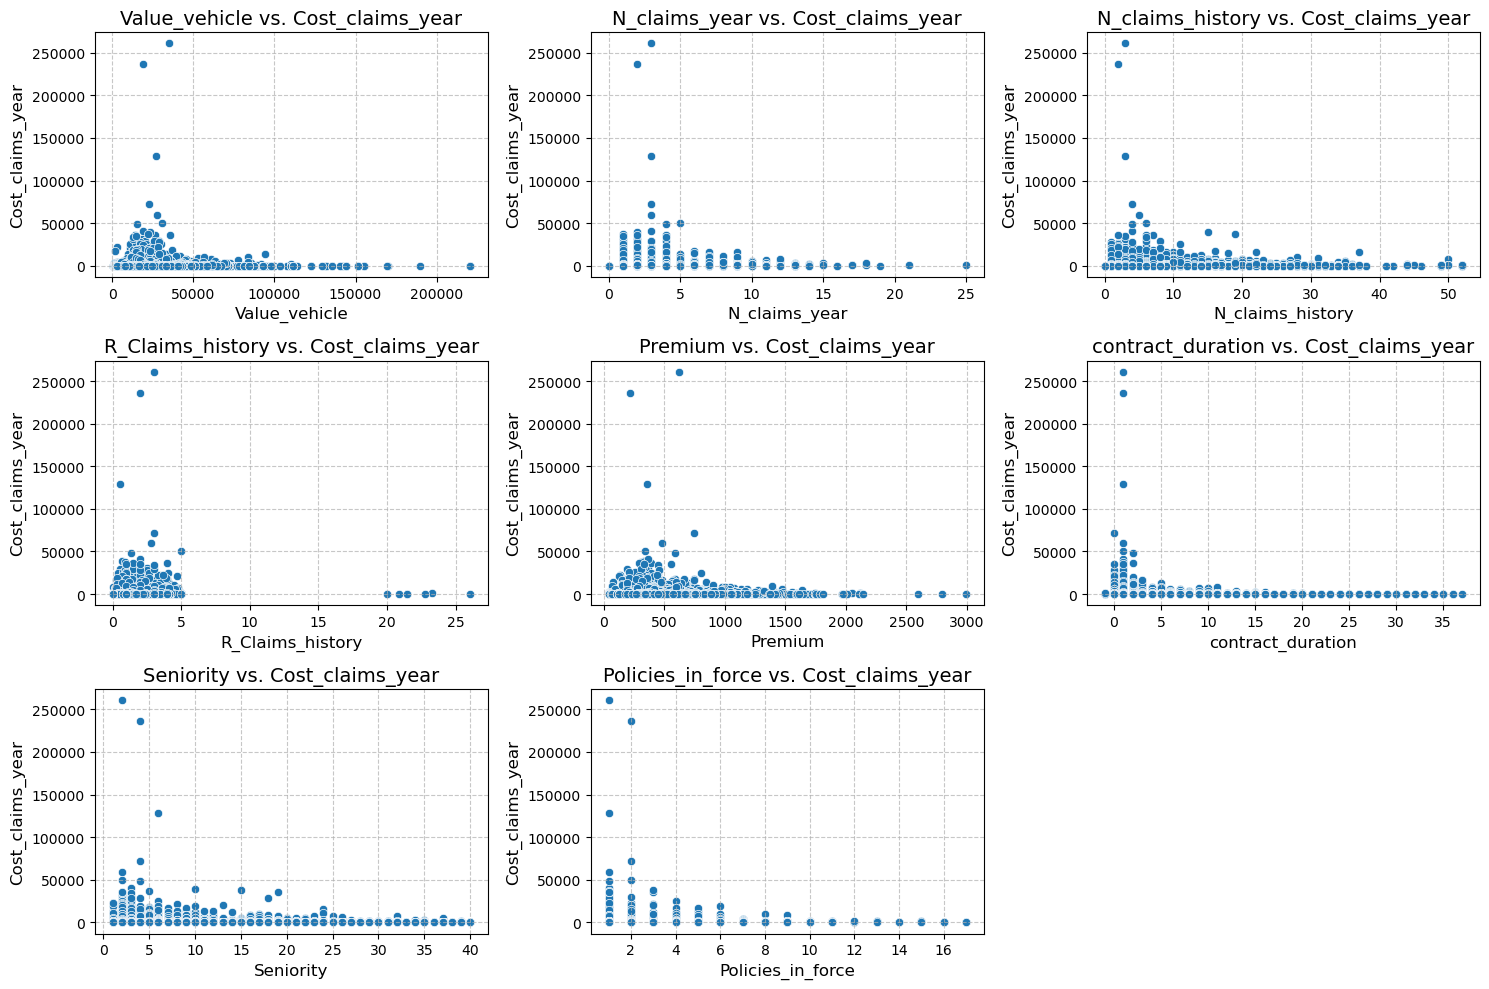

In [26]:
num_rows = 3  
num_cols = 3  

features = ['Value_vehicle',
            'N_claims_year', 'N_claims_history', 'R_Claims_history', 'Premium',
            'contract_duration', 'Seniority', 'Policies_in_force']

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

# Generate plots
for i, col in enumerate([f for f in features if f != 'Cost_claims_year']):  
    sns.scatterplot(x=df[col], y=df['Cost_claims_year'], ax=axes[i])  # Assign to correct subplot
    axes[i].set_title(f'{col} vs. Cost_claims_year', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Cost_claims_year', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.7)  # Add grid with dashed lines

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

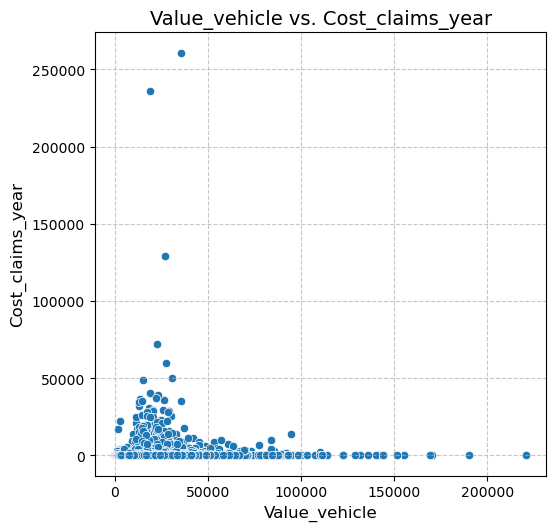

In [27]:
num_rows = 2  
num_cols = 3  

vehicle = ['Value_vehicle']

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

# Generate plots
for i, col in enumerate([f for f in vehicle if f != 'Cost_claims_year']):  
    sns.scatterplot(x=df[col], y=df['Cost_claims_year'], ax=axes[i])  # Assign to correct subplot
    axes[i].set_title(f'{col} vs. Cost_claims_year', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Cost_claims_year', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.7)  # Add grid with dashed lines

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

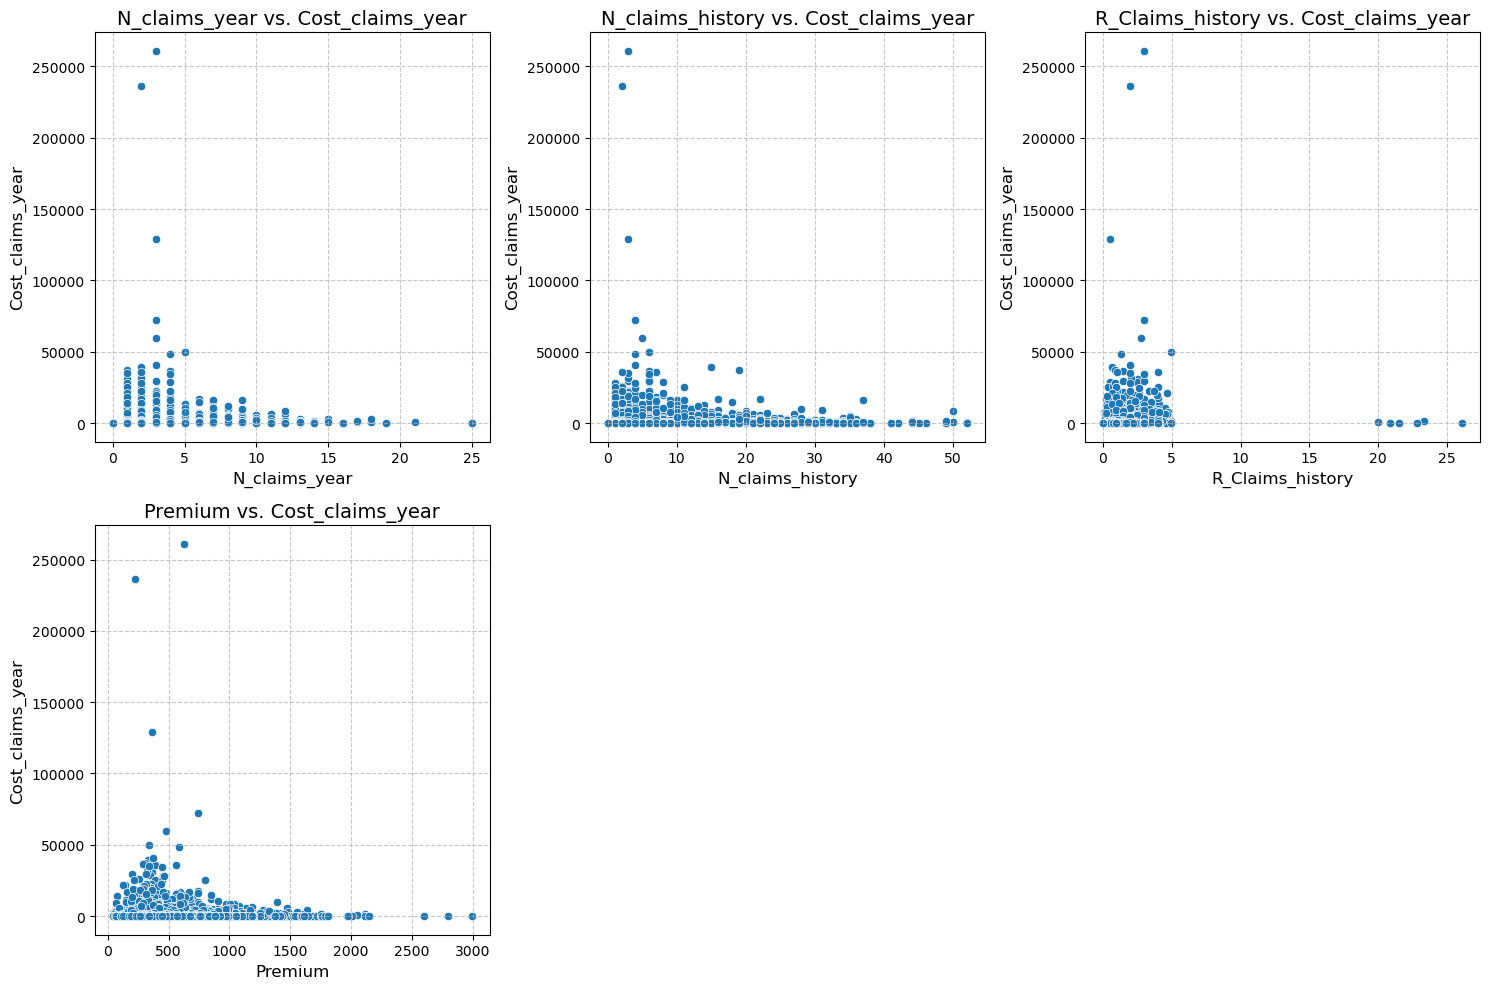

In [28]:
num_rows = 2  
num_cols = 3  

claim_history = ['N_claims_year', 'N_claims_history', 'R_Claims_history', 'Premium']

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

# Generate plots
for i, col in enumerate([f for f in claim_history if f != 'Cost_claims_year']):  
    sns.scatterplot(x=df[col], y=df['Cost_claims_year'], ax=axes[i])  # Assign to correct subplot
    axes[i].set_title(f'{col} vs. Cost_claims_year', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Cost_claims_year', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.7)  # Add grid with dashed lines

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

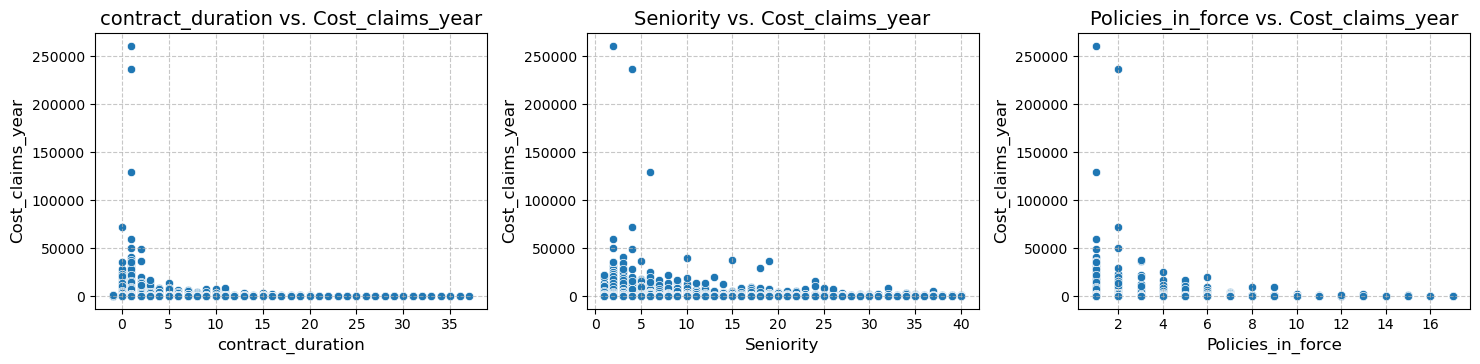

In [29]:
num_rows = 3  
num_cols = 3  

policy_customer = ['contract_duration', 'Distribution_channel', 
                   'Seniority', 'Policies_in_force', 'Payment']
policy_customer_num = ['contract_duration', 'Seniority', 'Policies_in_force']

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

# Generate plots
for i, col in enumerate([f for f in policy_customer_num if f != 'Cost_claims_year']):  
    sns.scatterplot(x=df[col], y=df['Cost_claims_year'], ax=axes[i])  # Assign to correct subplot
    axes[i].set_title(f'{col} vs. Cost_claims_year', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Cost_claims_year', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.7)  # Add grid with dashed lines

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Modeling

In [30]:
# Log Transformations to Handle Skewed Features
df['log_Cost_claims_year'] = np.log1p(df['Cost_claims_year'])
df['log_Value_vehicle'] = np.log1p(df['Value_vehicle'])
df['log_Premium'] = np.log1p(df['Premium'])

# Define independent features
independent_features = [
    'contract_duration', 'Distribution_channel', 'Seniority', 'Policies_in_force', 'Payment',  # Policy & Customer
    'N_claims_year', 'N_claims_history', 'R_Claims_history', 'log_Premium', # Claim History
    'log_Value_vehicle'  # Vehicle
]

# Drop rows with missing values in the selected features
df_vif = df[independent_features].dropna()

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(len(df_vif.columns))]

# Fit Linear Regression Model
X = df_vif
y = df['log_Cost_claims_year'].loc[X.index]

lr = LinearRegression()
lr.fit(X, y)

# Compute R-squared
r2 = r2_score(y, lr.predict(X))

# Display Results
print(f"Updated R2 Score: {r2}")
print(vif_data)


Updated R2 Score: 0.6066872761781646
                Feature         VIF
0     contract_duration    1.743245
1  Distribution_channel    1.988253
2             Seniority    3.599785
3     Policies_in_force    3.698404
4               Payment    1.620199
5         N_claims_year    1.797770
6      N_claims_history    2.660348
7      R_Claims_history    2.245410
8           log_Premium  220.822395
9     log_Value_vehicle  221.806871


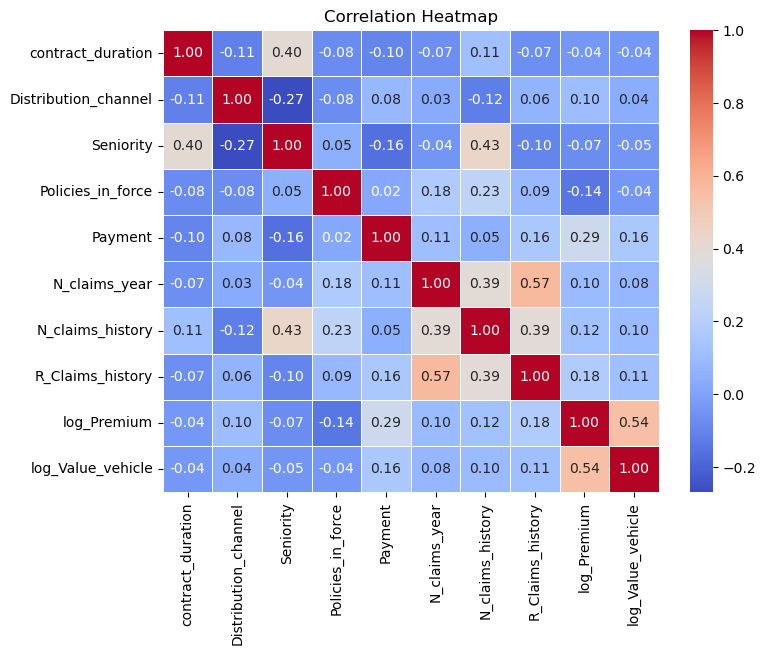

In [31]:
# Correlation Heatmap for independent_features
plt.figure(figsize=(8, 6))
corr_matrix = df[independent_features].select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Option 1: Drop one of the two high-VIF variables

In [32]:
X = X.drop(columns=['log_Value_vehicle'])

In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

In [34]:
#### 1. Keep log_Premium

In [35]:
# Feature selection
independent_features = [
    'contract_duration', 'Distribution_channel', 'Seniority', 'Policies_in_force', 'Payment',
    'N_claims_year', 'N_claims_history', 'R_Claims_history', 'log_Premium'
]

# Drop missing values
df_vif = df[independent_features].dropna()
X = df_vif
y = df['log_Cost_claims_year'].loc[X.index]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Fit Linear Regression Model
X = df_vif
y = df['log_Cost_claims_year'].loc[X.index]

lr = LinearRegression()
lr.fit(X, y)

# Compute R-squared
r2_lr = r2_score(y, lr.predict(X))

# Fit Ridge Regression Model
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)
r2_ridge = r2_score(y, ridge.predict(X))

# Display Results
print(f"Updated R2 Score (Linear Regression): {r2_lr}")
print(f"Updated R2 Score (Ridge Regression): {r2_ridge}")
print(vif_data)


Updated R2 Score (Linear Regression): 0.6064753331683604
Updated R2 Score (Ridge Regression): 0.6064753331268415
                Feature       VIF
0     contract_duration  1.743016
1  Distribution_channel  1.988253
2             Seniority  3.586813
3     Policies_in_force  3.551992
4               Payment  1.596571
5         N_claims_year  1.797249
6      N_claims_history  2.648361
7      R_Claims_history  2.243634
8           log_Premium  7.230760


#### 2. Keep Vehicle Feature

In [36]:
# Feature Selection (Dropping log_Premium due to high VIF)
independent_features = [
    'contract_duration', 'Distribution_channel', 'Seniority', 'Policies_in_force', 'Payment',  # Policy & Customer
    'N_claims_year', 'N_claims_history', 'R_Claims_history',  # Claim History
    'log_Value_vehicle'  # Vehicle Feature (retained)
]

# Drop rows with missing values in selected features
df_vif = df[independent_features].dropna()

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(len(df_vif.columns))]

print(vif_data)

                Feature       VIF
0     contract_duration  1.742656
1  Distribution_channel  1.973421
2             Seniority  3.598728
3     Policies_in_force  3.664979
4               Payment  1.570208
5         N_claims_year  1.796502
6      N_claims_history  2.654649
7      R_Claims_history  2.235390
8     log_Value_vehicle  7.262997


Better!

In [41]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.stats import lognorm, gamma, expon
from statsmodels.gam.api import GLMGam, BSplines


LinearRegression R2 Score: 0.6065
Ridge R2 Score: 0.6065
SVR R2 Score: 0.9406
DecisionTree R2 Score: 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 105555, number of used features: 9
[LightGBM] [Info] Start training from score 1.066631
LightGBM R2 Score: 0.9531
RandomForest R2 Score: 0.9920


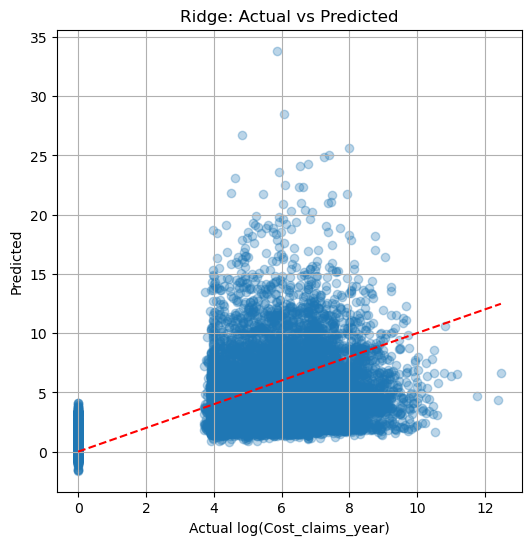

KeyError: 'log_Cost_claims_year'

In [42]:
# Models to evaluate
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "SVR": SVR(),
    "DecisionTree": DecisionTreeRegressor(),
    "LightGBM": lgb.LGBMRegressor(),
    "RandomForest": RandomForestRegressor()
}

for name, model in models.items():
    model.fit(X_scaled, y)
    preds = model.predict(X_scaled)
    score = r2_score(y, preds)
    print(f"{name} R2 Score: {score:.4f}")

# Best model predictions visualization
best_model = Ridge(alpha=1.0)
best_model.fit(X_scaled, y)
pred_y = best_model.predict(X_scaled)
plt.figure(figsize=(6, 6))
plt.scatter(y, pred_y, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual log(Cost_claims_year)")
plt.ylabel("Predicted")
plt.title("Ridge: Actual vs Predicted")
plt.grid(True)
plt.show()

# Distribution Fitting
data_to_fit = df_vif['log_Cost_claims_year']
x_vals = np.linspace(data_to_fit.min(), data_to_fit.max(), 200)

# Lognormal
params = lognorm.fit(data_to_fit)
pdf = lognorm.pdf(x_vals, *params)
plt.hist(data_to_fit, bins=50, density=True, alpha=0.5, label='Observed')
plt.plot(x_vals, pdf, label='Lognormal', color='red')
plt.title("Lognormal Fit")
plt.legend()
plt.grid(True)
plt.show()

# Gamma
params = gamma.fit(data_to_fit)
pdf = gamma.pdf(x_vals, *params)
plt.hist(data_to_fit, bins=50, density=True, alpha=0.5, label='Observed')
plt.plot(x_vals, pdf, label='Gamma', color='green')
plt.title("Gamma Fit")
plt.legend()
plt.grid(True)
plt.show()

# Exponential
params = expon.fit(data_to_fit)
pdf = expon.pdf(x_vals, *params)
plt.hist(data_to_fit, bins=50, density=True, alpha=0.5, label='Observed')
plt.plot(x_vals, pdf, label='Exponential', color='blue')
plt.title("Exponential Fit")
plt.legend()
plt.grid(True)
plt.show()

# GLM (Poisson)
X_const = sm.add_constant(X)
glm_poisson = sm.GLM(y, X_const, family=sm.families.Poisson())
poisson_result = glm_poisson.fit()
print("\nGLM Poisson Summary:\n", poisson_result.summary())

# Logistic Regression
y_binary = df_vif['High_Claim']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)
log_clf = LogisticRegression(max_iter=500)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nLogistic Regression Accuracy: {acc:.4f}")

# Generalized Additive Model (GAM)
spline_features = X[['contract_duration', 'Seniority']]
spline_basis = BSplines(spline_features, df=[6, 6], degree=[3, 3])
gam_model = GLMGam(endog=df_vif['High_Claim'], exog=sm.add_constant(X.drop(columns=['contract_duration', 'Seniority'])), smoother=spline_basis, family=sm.families.Binomial())
gam_results = gam_model.fit()
print("\nGAM Summary:\n", gam_results.summary())


In [43]:
# Models to evaluate
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "SVR": SVR(),
    "DecisionTree": DecisionTreeRegressor(),
    "LightGBM": lgb.LGBMRegressor(),
    "RandomForest": RandomForestRegressor()
}

for name, model in models.items():
    model.fit(X_scaled, y)
    preds = model.predict(X_scaled)
    score = r2_score(y, preds)
    print(f"{name} R2 Score: {score:.4f}")



LinearRegression R2 Score: 0.6065
Ridge R2 Score: 0.6065


In [ ]:
# Best model predictions visualization
best_model = Ridge(alpha=1.0)
best_model.fit(X_scaled, y)
pred_y = best_model.predict(X_scaled)
plt.figure(figsize=(6, 6))
plt.scatter(y, pred_y, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual log(Cost_claims_year)")
plt.ylabel("Predicted")
plt.title("Ridge: Actual vs Predicted")
plt.grid(True)
plt.show()


In [ ]:
# Lognormal
params = lognorm.fit(data_to_fit)
pdf = lognorm.pdf(x_vals, *params)
plt.hist(data_to_fit, bins=50, density=True, alpha=0.5, label='Observed')
plt.plot(x_vals, pdf, label='Lognormal', color='red')
plt.title("Lognormal Fit")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Gamma
params = gamma.fit(data_to_fit)
pdf = gamma.pdf(x_vals, *params)
plt.hist(data_to_fit, bins=50, density=True, alpha=0.5, label='Observed')
plt.plot(x_vals, pdf, label='Gamma', color='green')
plt.title("Gamma Fit")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Exponential
params = expon.fit(data_to_fit)
pdf = expon.pdf(x_vals, *params)
plt.hist(data_to_fit, bins=50, density=True, alpha=0.5, label='Observed')
plt.plot(x_vals, pdf, label='Exponential', color='blue')
plt.title("Exponential Fit")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# GLM (Poisson)
X_const = sm.add_constant(X)
glm_poisson = sm.GLM(y, X_const, family=sm.families.Poisson())
poisson_result = glm_poisson.fit()
print("\nGLM Poisson Summary:\n", poisson_result.summary())


In [ ]:
# Logistic Regression
y_binary = df_vif['High_Claim']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)
log_clf = LogisticRegression(max_iter=500)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nLogistic Regression Accuracy: {acc:.4f}")


In [ ]:
# Generalized Additive Model (GAM)
spline_features = X[['contract_duration', 'Seniority']]
spline_basis = BSplines(spline_features, df=[6, 6], degree=[3, 3])
gam_model = GLMGam(endog=df_vif['High_Claim'], exog=sm.add_constant(X.drop(columns=['contract_duration', 'Seniority'])), smoother=spline_basis, family=sm.families.Binomial())
gam_results = gam_model.fit()
print("\nGAM Summary:\n", gam_results.summary())


In [35]:
from scipy.stats import lognorm, norm

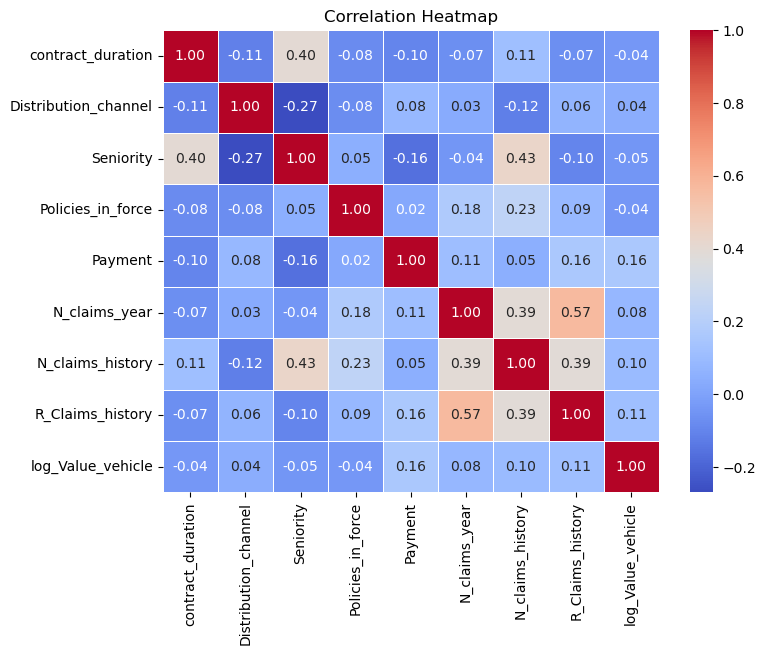

Updated R2 Score (Linear Regression): 0.6065983958525818
Updated R2 Score (Ridge Regression): 0.6065983958113753
                  Generalized Linear Model Regression Results                   
Dep. Variable:     log_Cost_claims_year   No. Observations:               105555
Model:                              GLM   Df Residuals:                   105546
Model Family:                   Poisson   Df Model:                            8
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:            -1.6893e+05
Date:                  Sat, 22 Mar 2025   Deviance:                   2.6734e+05
Time:                          01:08:36   Pearson chi2:                 3.20e+05
No. Iterations:                      13   Pseudo R-squ. (CS):             0.6697
Covariance Type:              nonrobust                                         
                           coef    std err          z      P>|z|      [0.025 

,Feature,VIF
0,contract_duration,1.742656
1,Distribution_channel,1.973421
2,Seniority,3.598728
3,Policies_in_force,3.664979
4,Payment,1.570208
5,N_claims_year,1.796502
6,N_claims_history,2.654649
7,R_Claims_history,2.235390
8,log_Value_vehicle,7.262997


In [36]:
# Log Transformations to Handle Skewed Features
df['log_Cost_claims_year'] = np.log1p(df['Cost_claims_year'])
df['log_Value_vehicle'] = np.log1p(df['Value_vehicle'])
df['log_Premium'] = np.log1p(df['Premium'])


# Interaction Term
df['log_Value_x_Premium'] = df['log_Value_vehicle'] * df['log_Premium']

# Define independent features (Removing `log_Value_x_Premium` to avoid collinearity)
independent_features = [
    'contract_duration', 'Distribution_channel', 'Seniority', 'Policies_in_force', 'Payment',
    'N_claims_year', 'N_claims_history', 'R_Claims_history',
    'log_Value_vehicle'
]

# Drop rows with missing values in the selected features
df_vif = df[independent_features].dropna()

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(len(df_vif.columns))]

# Fit Linear Regression Model
X = df_vif
y = df['log_Cost_claims_year'].loc[X.index]

lr = LinearRegression()
lr.fit(X, y)
r2_lr = r2_score(y, lr.predict(X))

# Fit Ridge Regression Model
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)
r2_ridge = r2_score(y, ridge.predict(X))

# Fit Generalized Linear Model (Poisson)
poisson_glm = sm.GLM(y, X, family=sm.families.Poisson())
poisson_model = poisson_glm.fit()

# Plot Correlation Heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(df_vif.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Display Results
print(f"Updated R2 Score (Linear Regression): {r2_lr}")
print(f"Updated R2 Score (Ridge Regression): {r2_ridge}")
print(poisson_model.summary())
vif_data